### Importing relevant library

In [1]:
import numpy as np
import pandas as pd

In [2]:
import yfinance as yf

### Downloading the TESLA stock data

In [3]:
Tesla = yf.download(tickers='TSLA', 
                   start = '2016-01-01')
Tesla.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,47.702000,48.689999,47.674000,48.001999,48.001999,13575000
2016-01-04,46.144001,46.276001,43.799999,44.681999,44.681999,34135500
2016-01-05,45.271999,45.377998,44.000000,44.686001,44.686001,15934000
2016-01-06,44.000000,44.009998,43.195999,43.807999,43.807999,18895500
2016-01-07,42.838001,43.688000,42.734001,43.130001,43.130001,17771500


## Pre-Processing the input data

In [4]:
## Choosing 'Close' price for evaluation.
tesla = Tesla['Close'].reset_index()
tesla.drop('Date', axis=1, inplace=True)
tesla.head()

,Close
0,48.001999
1,44.681999
2,44.686001
3,43.807999
4,43.130001


In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (21,6)
plt.style.use('fivethirtyeight')

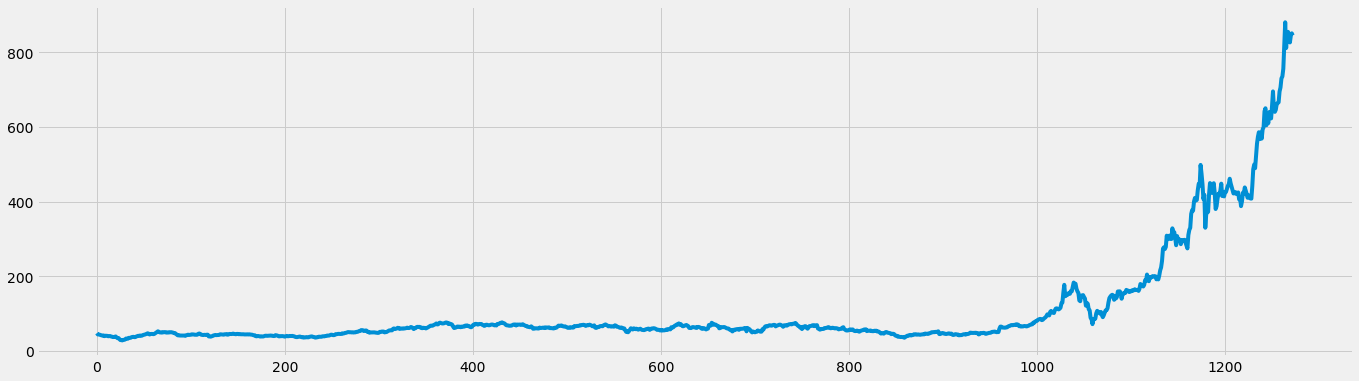

In [6]:
plt.plot(tesla)

In [7]:
tesla.shape

(1273, 1)

In [8]:
## We can see a clear uptrend post 800th trading session. It was caused due to an extraordinary event of spaceX ( pvt company held
## by Tesla founder Elon Musk) being able to bring back their rocket vehicle on Earth perfectly.
## Hence, taking data points since 0th trading session will lead to bias. So, it needs to truncated.

In [9]:
tesla = tesla[800:]
tesla = tesla.reset_index()
tesla.head()

,index,Close
0,800,56.827999
1,801,58.183998
2,802,56.672001
3,803,57.792000
4,804,57.992001


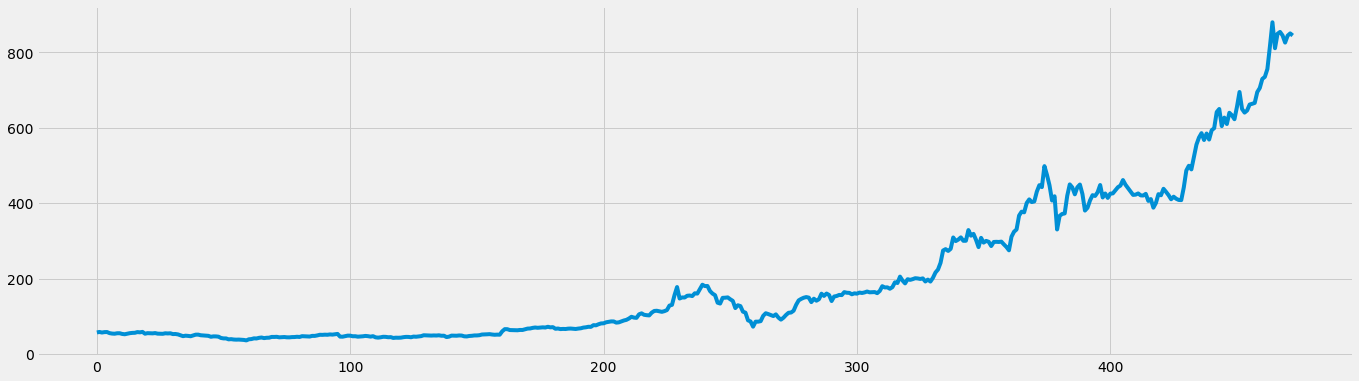

In [10]:
tesla.drop('index',axis=1,inplace=True)
plt.plot(tesla)

#### Scaling the input data

In [11]:
## LSTM model is senstive to the scale of the data. So we will scale the prices with MaxMinScaler

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
tesla_scaled=scaler.fit_transform(np.array(tesla).reshape(-1,1)) 
## MinMaxScaler works with 2 or more than 2 dimensional data. So it needs to be reshaped
## Dataframe cannot be reshaped. So it needs to be converted into array.

In [13]:
tesla_scaled[:5]

array([[0.02491513],
       [0.02652133],
       [0.02473035],
       [0.026057  ],
       [0.02629391]])

### Splitting the data into train, validation and test 

In [14]:
## length selection for train, validation and test data

train_length = int(0.65 * len(tesla_scaled))
validation_length = int(0.20 * len(tesla_scaled))
test_length = len(tesla_scaled) - train_length - validation_length

In [15]:
train_data       = tesla_scaled[ : train_length]   
validation_data  = tesla_scaled[ train_length : train_length + validation_length]
test_data        = tesla_scaled[ train_length + validation_length : ]

print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(307, 1)
(94, 1)
(72, 1)


In [16]:
## defining the splitting function

def X_Y_split(data,timestamp : int):
    dataX , dataY = [], []
    for i in range(len(data)-timestamp):
        dataX.append(data[i:i+timestamp])
        dataY.append(data[i+timestamp])
    return np.array(dataX), np.array(dataY)   
## converted to array because later we need to reshape it into 3D for LSTM.
## list cannot be reshaped.

In [17]:
timestamp = 22 # Usually a month consists of 22 trading sessions. So, we'll try to predict the stock price based on last 1 month performance.
train_X, train_Y = X_Y_split(train_data, timestamp)
validation_X, validation_Y = X_Y_split(validation_data, timestamp)
test_X, test_Y = X_Y_split(test_data, timestamp)

In [18]:
print(train_X.shape, train_Y.shape)
print(validation_X.shape, validation_Y.shape)
print(test_X.shape, test_Y.shape)

(285, 22, 1) (285, 1)
(72, 22, 1) (72, 1)
(50, 22, 1) (50, 1)


### Importing Deep Learning model useful libraries

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

### LSTM Model creation

In [20]:
model=Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(22,1)))
##model.add(Dropout(0.1))

model.add(LSTM(50,return_sequences=True))
##model.add(Dropout(0.1))

model.add(LSTM(50))
##model.add(Dropout(0.1))

model.add(Dense(1))

In [21]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 22, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 22, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### Creating CallBack for Early stopping of training to avoid overfitting

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
Early_Stopping = EarlyStopping(min_delta=0.005, mode='min', patience=3)

### Fitting and Training the model

In [24]:
model.fit(train_X, train_Y,validation_data=(validation_X, validation_Y),epochs=50,batch_size=50,callbacks=[Early_Stopping],verbose=1)

Epoch 1/50
6/6 [==============================] - 2s 314ms/step - loss: 0.0024 - val_loss: 0.0260
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 9.8661e-04 - val_loss: 0.0105
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 5.9060e-04 - val_loss: 0.0034
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 4.6228e-04 - val_loss: 0.0042
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 3.8905e-04 - val_loss: 0.0046
Epoch 6/50
6/6 [==============================] - 0s 22ms/step - loss: 3.8000e-04 - val_loss: 0.0073


### Model Evaluation

In [25]:
model.evaluate(test_X, test_Y, verbose=1)

2/2 [==============================] - 0s 3ms/step - loss: 0.0388


0.038803696632385254

In [26]:
test_predict = model.predict(test_X)

In [27]:
test_Y_unscaled = scaler.inverse_transform(test_Y)
test_predict_unscaled = scaler.inverse_transform(test_predict)

In [28]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_Y_unscaled, test_predict_unscaled)
rmse = np.sqrt(mse)
print("RMSE Score :", rmse)


RMSE Score : 166.3011919950376


### Real Stock Price vs Predicted Stock Price

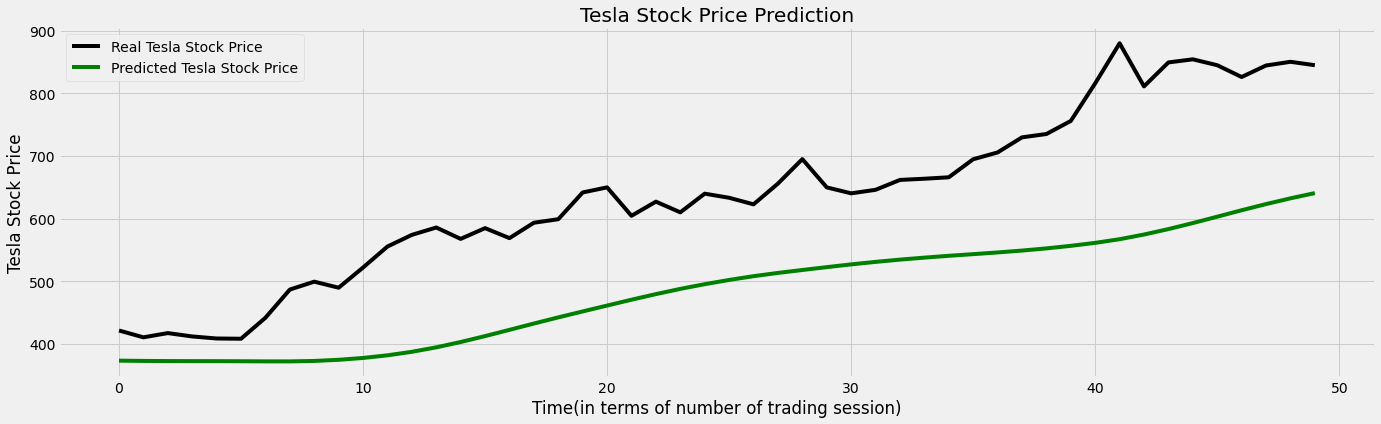

In [29]:
plt.plot(test_Y_unscaled, color = 'black', label = 'Real Tesla Stock Price')
plt.plot(test_predict_unscaled, color = 'green', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time(in terms of number of trading session)')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

## Now let us predict the Tesla Stock Price for next 1 month, i.e, for next 22 trading sessions

In [30]:
## Last 22 trading session closing prices, alongwith next 22 trading session prediction price needs an empty array of size 44.
new_data = np.empty(44)

In [31]:
## Copying the last 22 trading session closing price into a new_data
for i in range(22):
    new_data[i] = test_data[50+i]

In [32]:
new_predict = []
i = 0 
while i<22:
    temp  = new_data[i:i+timestamp]      
    temp  = temp.reshape(1,timestamp,1)
    y_hat = model.predict(temp)
    new_data[i+timestamp] = y_hat               
    new_predict.extend(y_hat)                ## extend is applied with list, not ndarray
    i = i+1


In [33]:
new_predict ## Predicted Closing Price for next 22 trading sessions

[array([0.7253988], dtype=float32),
 array([0.73136944], dtype=float32),
 array([0.7336614], dtype=float32),
 array([0.73211473], dtype=float32),
 array([0.7271105], dtype=float32),
 array([0.71928525], dtype=float32),
 array([0.7093601], dtype=float32),
 array([0.697992], dtype=float32),
 array([0.685733], dtype=float32),
 array([0.67306226], dtype=float32),
 array([0.66030675], dtype=float32),
 array([0.6477184], dtype=float32),
 array([0.63542914], dtype=float32),
 array([0.62351334], dtype=float32),
 array([0.61205167], dtype=float32),
 array([0.60115445], dtype=float32),
 array([0.5906571], dtype=float32),
 array([0.5805879], dtype=float32),
 array([0.570922], dtype=float32),
 array([0.56162083], dtype=float32),
 array([0.5526173], dtype=float32),
 array([0.5439201], dtype=float32)]

### Last 22 closing prices vs expected next 22 closing prices. 

Text(0, 0.5, 'Tesla Stock Price')

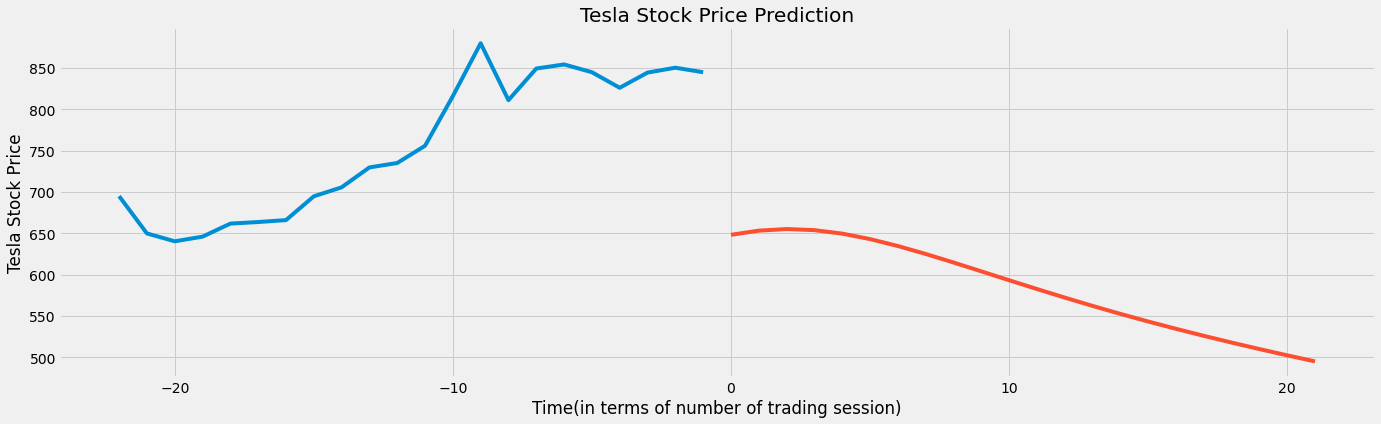

In [34]:
plt.plot(np.arange(-22,0), scaler.inverse_transform(test_data[50:]))
plt.plot(np.arange(0,22), scaler.inverse_transform(new_predict))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time(in terms of number of trading session)')
plt.ylabel('Tesla Stock Price')

Text(0, 0.5, 'Tesla Stock Price')

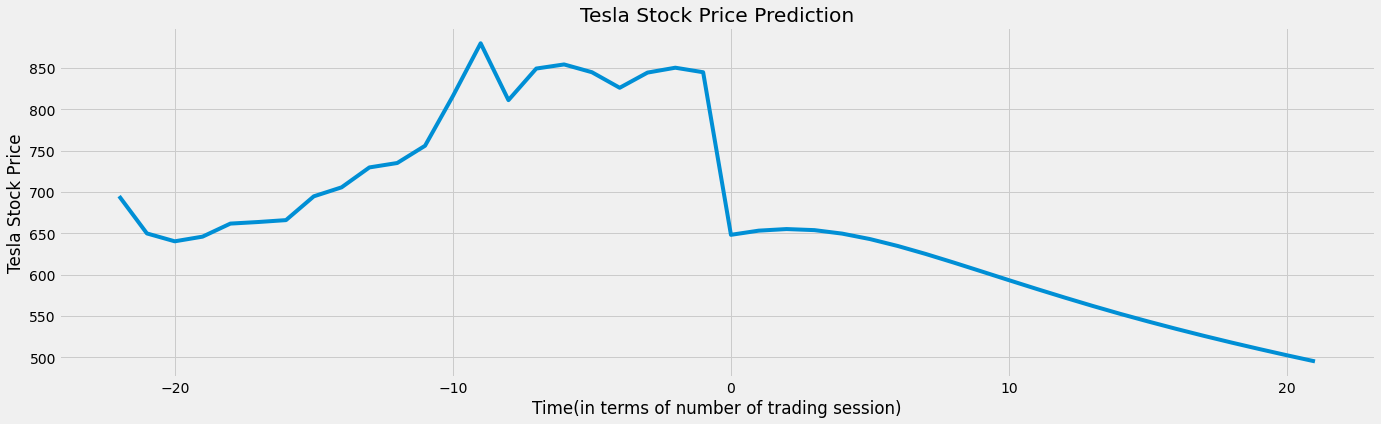

In [35]:
## Combined plot of last 22 closing prices and expected next 22 closing prices 

new_data = new_data.reshape(-1,1)
plt.plot(np.arange(-22,22), scaler.inverse_transform(new_data))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time(in terms of number of trading session)')
plt.ylabel('Tesla Stock Price')

## Plotting overall stock price movement alongwith the predicted next 22 trading session prices

In [36]:
tesla_total = tesla_scaled.tolist()  ## type converting into list so that new_predicted can be added into the list.
tesla_total.extend(new_predict)

In [37]:
tesla_total[-22:]

[array([0.7253988], dtype=float32),
 array([0.73136944], dtype=float32),
 array([0.7336614], dtype=float32),
 array([0.73211473], dtype=float32),
 array([0.7271105], dtype=float32),
 array([0.71928525], dtype=float32),
 array([0.7093601], dtype=float32),
 array([0.697992], dtype=float32),
 array([0.685733], dtype=float32),
 array([0.67306226], dtype=float32),
 array([0.66030675], dtype=float32),
 array([0.6477184], dtype=float32),
 array([0.63542914], dtype=float32),
 array([0.62351334], dtype=float32),
 array([0.61205167], dtype=float32),
 array([0.60115445], dtype=float32),
 array([0.5906571], dtype=float32),
 array([0.5805879], dtype=float32),
 array([0.570922], dtype=float32),
 array([0.56162083], dtype=float32),
 array([0.5526173], dtype=float32),
 array([0.5439201], dtype=float32)]

Text(0, 0.5, 'Tesla Stock Price')

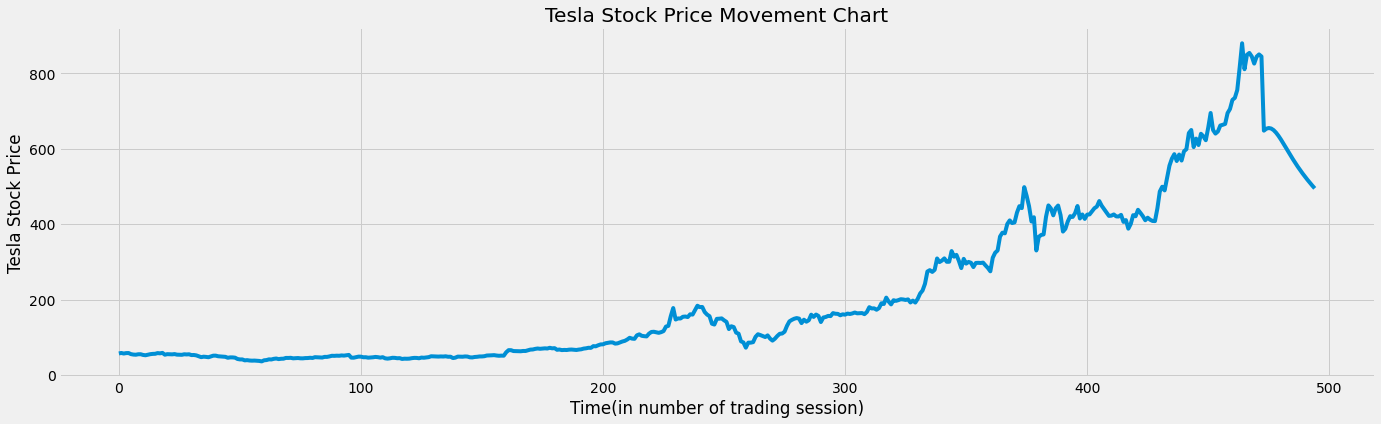

In [38]:
plt.plot(scaler.inverse_transform(tesla_total))
plt.title('Tesla Stock Price Movement Chart')
plt.xlabel('Time(in number of trading session)')
plt.ylabel('Tesla Stock Price')

## Conclusion

### As predicted by the LSTM model, the Tesla stock price is predicted to fall for the next 1 month, i.e., 22 trading sessions.